In [5]:
import os
import random
import glob
import gc  # garbage collector

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import cv2
# import albumentations as A  # for image data augmentation

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, Input, MaxPooling2D, 
                                     Dropout, concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

# pytorch
# import torch
# import torch.nn as nn
# import torch.functional as F

import warnings
warnings.filterwarnings('ignore')

2024-07-20 08:31:07.448821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 08:31:07.448923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 08:31:07.573531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Please ensure CUDA and cuDNN are properly installed.")

2 Physical GPUs, 2 Logical GPUs


# Utility functions

In [7]:
FULL_SHAPE = (768, 768)
# NEW_SHAPE = (256, 256)
NEW_SHAPE = (128, 128)

In [8]:
def rle_decode(mask_rle, shape=(768, 768)) -> np.array:
    """
    decode run-length encoded segmentation mask
    Assumed all images aRe 768x768 (and ThereforE have the saMe shape)
    """
    
    # if no segmentation mask (nan) return matrix of zeros
    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    # RLE sequence str split to and map to int
    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # indices: 2k - starts, 2k+1 lengths
    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T

In [9]:
def rle_encode():
    return

In [44]:
def dice_coeff(y_true, y_pred, smooth=1.0):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def BCE_dice(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) + (1 - dice_coeff(y_true, y_pred))

In [11]:
def create_dataset(image_dir: str, image_filenames: list[str], image_masks: pd.DataFrame) -> tuple:
    # for each image filename
    # read original image using cv2
    # compute segmentations using RLE from image_masks dataframe
    # append each to tensorflow tensor or smth
    
    images = []
    masks = []
    
    for i, image_filename in enumerate(image_filenames):
        image_path = f"{image_dir}/{image_filename}"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, NEW_SHAPE)
        
        # get RLE sequences for current image
        mask_rles = image_masks[image_masks['ImageId'] == image_filename]['EncodedPixels']
        mask = np.zeros(FULL_SHAPE, dtype=np.uint8)  # init empty mask

        for rle in mask_rles:
            mask += rle_decode(rle)
        
        mask = cv2.resize(mask, NEW_SHAPE)
        image = image / 255.0

        images.append(image)
        masks.append(mask)

    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    masks_tensor = tf.convert_to_tensor(masks, dtype=tf.uint8)

    return images_tensor, masks_tensor

# Prepare data for U-Net

In [12]:
train_folder_path = '/kaggle/input/airbus-ship-detection/train_v2'
train_masks_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'
test_folder_path = '/kaggle/input/airbus-ship-detection/test_v2'

In [13]:
train_masks_df = pd.read_csv(train_masks_path)

In [14]:
class ShipDataset(keras.utils.Sequence):
    def __init__(self, image_dir: str, image_mask_rle_path: str, image_size=(256, 256), batch_size=128):
        # data loader params
        self.image_size = image_size
        self.batch_size = batch_size
        # read run-length encoded ships dataframe
        self.image_masks_rle_df = pd.read_csv(image_mask_rle_path)
        self.image_filenames = self.image_masks_rle_df['ImageId'].unique()  # get unique image filenames
        print(self.image_filenames)
        
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        pass

    def on_epoch_end(self):
        """
        Updates indices after each epoch
        """
        # Shuffle indices after each epoch
        pass

    def _load_image(self, image_path):
        """
        Load and preprocess an image
        :param image_path: Path to the image
        :return: Preprocessed image array
        """
        # Load and preprocess an image
        pass

In [15]:
class ShipDatasetModified(keras.utils.Sequence):
    
    def __init__(self, image_dir, image_filenames, image_size=(256, 256), batch_size=128):
        # data loader params
        self.image_size = image_size
        self.batch_size = batch_size
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        # read run-length encoded ships
        self.image_masks_df = pd.read_csv(train_masks_path)
    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index: Index of the batch
        :return: Batch of images and masks
        """
        # create batch indices
        batch_indices = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        
        # create arrays for images and masks
        batch_images = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.uint8)
        
        for i, current_image_name in enumerate(batch_indices):
            try:
                # read image and convert to rgb
                image = cv2.imread(os.path.join(self.image_dir, current_image_name))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # get segmentation mask using image filename
                img_rle_seqs = self.image_masks_df.loc[self.image_masks_df['ImageId'] == current_image_name]['EncodedPixels']
                image_mask = np.zeros(FULL_SHAPE, dtype=np.uint8)  # empty mask
                
                for rle in img_rle_seqs:
                    image_mask += rle_decode(rle)
                
                # resize img and its mask
                image = cv2.resize(image, self.image_size)
                image_mask = cv2.resize(image_mask, self.image_size)
                
                image = image / 255.0  # Normalize to [0, 1]
                
                batch_images[i] = image
                batch_masks[i] = np.expand_dims(image_mask, axis=-1)
                
            except Exception as e:
                print(f"Error processing image {current_image_name}: {e}")
        
        return batch_images, batch_masks

    def on_epoch_end(self):
        """
        Updates indices after each epoch
        """
        # shuffle inplace after last batch in epoch
        random.shuffle(self.image_filenames)

    def _load_image(self, image_path):
        """
        Load and preprocess an image
        :param image_path: Path to the image
        :return: Preprocessed image array
        """
        # Load and preprocess an image
        pass

In [16]:
image_filenames = [os.path.basename(filename) for filename in glob.glob(train_folder_path + '/*')]
# random.Random(42).shuffle(image_filenames)
print(image_filenames[:10])
ratio = .8
split_index = int(ratio * len(image_filenames))
train_filenames, val_filenames = image_filenames[: split_index], image_filenames[split_index:]

train_ship_dataset = ShipDatasetModified(train_folder_path, train_filenames)
val_ship_dataset = ShipDatasetModified(train_folder_path, val_filenames)

len(train_ship_dataset), len(val_ship_dataset)

['d8bc90fd6.jpg', 'ee783cf9f.jpg', '4b0d96146.jpg', '7c8d78c3f.jpg', '290f37d66.jpg', '6a91a5706.jpg', '43fa8864a.jpg', '018c1ff4d.jpg', 'a93de8732.jpg', 'e97cb9839.jpg']


(154044, 38512)

In [17]:
train_ship_dataset[0][0].shape

(128, 256, 256, 3)

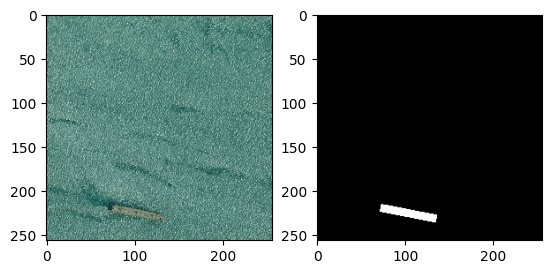

In [18]:
i = 6
some_image, some_mask = train_ship_dataset[0]
some_image = some_image[i]
some_mask = some_mask[i]

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(some_image)
ax[1].imshow(some_mask, cmap='gray')
plt.show()

In [19]:
random.Random(42).shuffle(image_filenames)
train_filenames, val_filenames = image_filenames[: split_index], image_filenames[split_index:]

# random.Random(42).shuffle(train_filenames)
# random.Random(42).shuffle(val_filenames)

# get slice of whole data (i dont want to transform images and compute masks every time i get an dataset item)
train_filenames = train_filenames[:9000]
val_filenames = val_filenames[:1000]

# remove images which does not contain any ships (later)

print(len(train_filenames), len(val_filenames))

gc.collect()

9000 1000


108

In [20]:
X_train, y_train = create_dataset(train_folder_path, train_filenames, train_masks_df)
X_val, y_val = create_dataset(train_folder_path, val_filenames, train_masks_df)

In [21]:
X_train.shape, y_train.shape

(TensorShape([9000, 128, 128, 3]), TensorShape([9000, 128, 128]))

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# train_dataset_iterator = train_dataset.as_numpy_iterator()
# val_dataset_iterator = val_dataset.as_numpy_iterator()

batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)  # no need to shuffle validation data

# U-Net model for segmentation problem

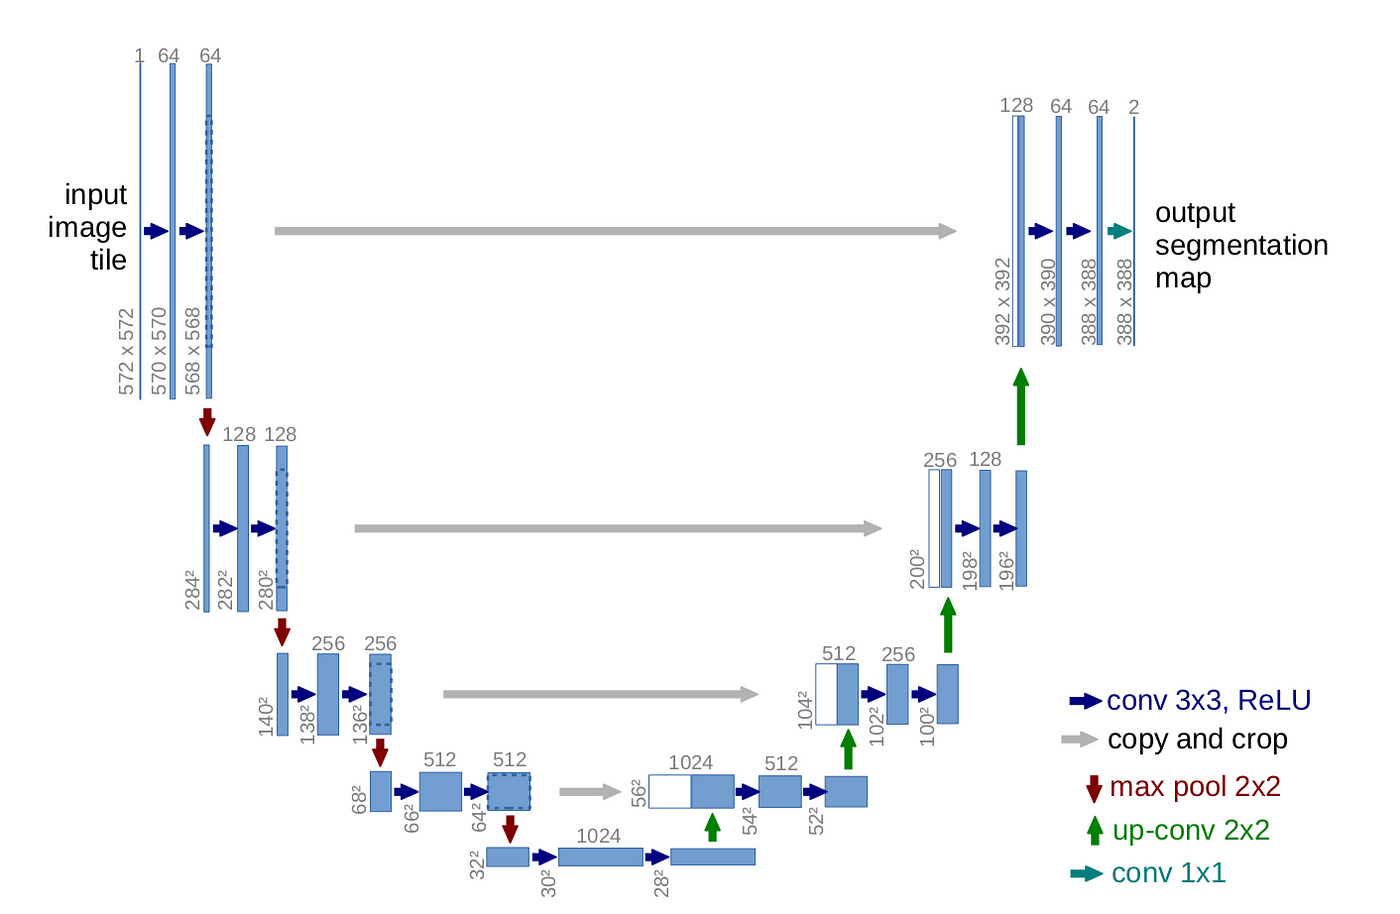


In [23]:
def create_conv2d_block(input_tensor, num_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    
    # 1st layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
        
    x = keras.layers.Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    
    return x

In [24]:
def create_unet(input_shape, num_filters=16, dropout=0.1, batchnorm=True):
    """
    Function to define the UNET Model
    input_shape: (height, width, 3)
    """
    
    assert input_shape[-1] == 3  # image must have 3 channels
    
    # input 'layer'
    #input_img = Input((*input_shape, 3), name='img')
    input_img = Input(input_shape, name='img')
    
    # downsampling (encoder)
    c1 = create_conv2d_block(input_img, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = create_conv2d_block(p1, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = create_conv2d_block(p2, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = create_conv2d_block(p3, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck
    c5 = create_conv2d_block(p4, num_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling (decoder)
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = create_conv2d_block(u6, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = create_conv2d_block(u7, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = create_conv2d_block(u8, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = create_conv2d_block(u9, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [49]:
input_shape = (*NEW_SHAPE, 3)

unet_model = create_unet(input_shape)

metrics = [
    'accuracy',
    dice_coeff,
    dice_loss,
]

# unet_model.compile(optimizer=Adam(0.0005), loss="binary_crossentropy", metrics=metrics)
unet_model.compile(optimizer=Adam(0.0005), loss=BCE_dice, metrics=metrics)

gc.collect()

4

In [50]:
unet_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 128, 128,  │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_109      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ activation_109[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 64, 64,    │          0 │ max_pooling2d_24… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 64, 64,    │      4,640 │ dropout_48[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_111      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ activation_111[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 32, 32,    │          0 │ max_pooling2d_25… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 32, 32,    │     18,496 │ dropout_49[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_113      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 16, 16,    │          0 │ activation_113[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 16, 16,    │          0 │ max_pooling2d_26… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 16, 16,    │     73,856 │ dropout_50[0][0]

 Total params: 1,179,409 (4.50 MB)

 Trainable params: 1,177,937 (4.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [51]:
callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='./logs')
]

In [52]:
# history = unet_model.fit(
#     train_ship_dataset,
#     validation_data=val_ship_dataset,
#     callbacks=callbacks,
#     epochs=5
# )

history = unet_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9272 - dice_coeff: 0.0024 - dice_loss: 0.9976 - loss: 1.3873
Epoch 1: val_loss improved from inf to 1.18856, saving model to model-Unet.weights.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 235ms/step - accuracy: 0.9275 - dice_coeff: 0.0024 - dice_loss: 0.9976 - loss: 1.3866 - val_accuracy: 0.9988 - val_dice_coeff: 0.0026 - val_dice_loss: 0.9974 - val_loss: 1.1886
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9983 - dice_coeff: 0.0033 - dice_loss: 0.9967 - loss: 1.1457
Epoch 2: val_loss improved from 1.18856 to 1.08937, saving model to model-Unet.weights.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.9983 - dice_coeff: 0.0033 - dice_loss: 0.9967 - loss: 1.1455 - val_accuracy: 0.9988 - val_dice_coeff: 0.0038 - val_dice_loss: 0.9962 - val_loss: 1.0894
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9987 - dice_coeff: 0.0060 - dice_loss: 0.9940 - loss: 1.0857
Epoch 3: val_loss im

# Save training results

In [54]:
import pickle

with open('unet_history.obj', 'wb') as f:
    pickle.dump(history.history, f)

unet_model.save_weights('winstarsai_airbus_unet.weights.h5')